In [150]:
import numpy as np 
import pandas as pd 
import os
import glob
import matplotlib.pyplot as plt

from scipy.io import loadmat

import PIL
import cv2

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Transfert Learning
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input as Xception_preprocessor
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_v3_preprocessor
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50

from tensorflow.keras.models import load_model

import shutil
from sklearn.model_selection import train_test_split

# Récupération des données

In [ ]:
os.mkdir("train")
os.mkdir("test")
os.mkdir("val")

images_folder='Images'
for folder in os.listdir('Images'):
    os.makedirs("train/" + folder)
    os.makedirs("test/" + folder)
    os.makedirs("val/" + folder)

In [ ]:
dict={}
for i in os.listdir('Images'):
    dict[i]=0
    for j in os.listdir('Images/{}'.format(i)):
        dict[i]+=1

for i in os.listdir('Images'):
    a=0
    for j in os.listdir('Images/{}'.format(i)):
        path="Images/{}/{}".format(i,j)
        liste=list(range(0,dict[i]))
        train,test=train_test_split(liste, test_size=0.2, random_state=1)
        train,val=train_test_split(train, test_size=0.2, random_state=1)
        if a in train:
            shutil.copy(path, "train/{}/{}".format(i,j))
        if a in test:
            shutil.copy(path, "test/{}/{}".format(i,j))
        if a in val:
            shutil.copy(path, "val/{}/{}".format(i,j))
        a+=1

## Voici quelques chihuahuas:

In [120]:
chihuahuas = list(glob.glob('Images/n02085620-Chihuahua/*'))

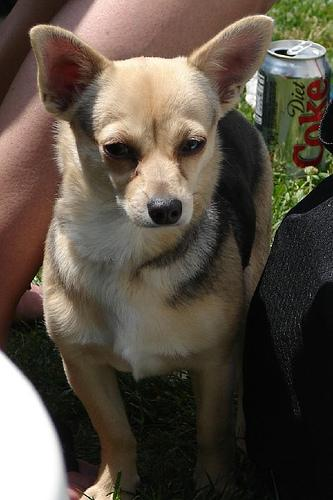

In [121]:
PIL.Image.open(str(chihuahuas[0]))

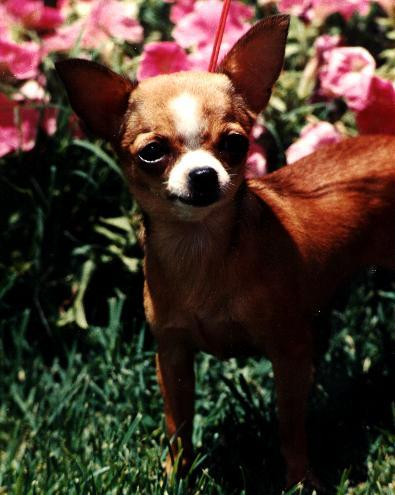

In [122]:
PIL.Image.open(str(chihuahuas[1]))

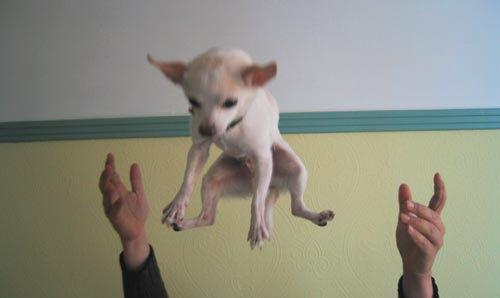

In [123]:
PIL.Image.open(str(chihuahuas[2]))

# Voici quelques bassets :

In [125]:
basset = list(glob.glob('Images/n02088238-basset/*'))

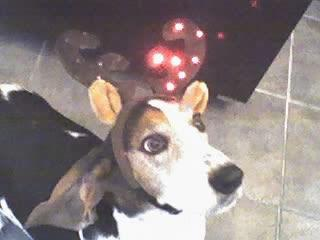

In [126]:
PIL.Image.open(str(basset[0]))

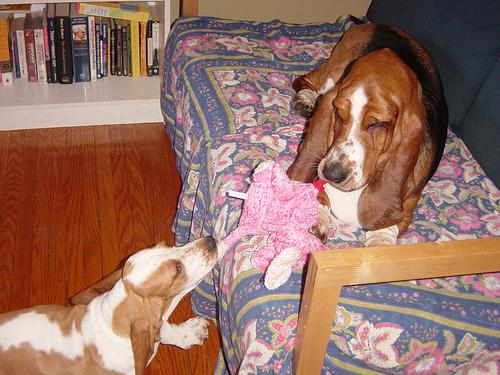

In [127]:
PIL.Image.open(str(basset[1]))

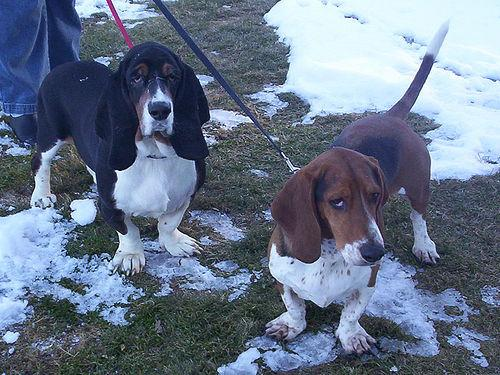

In [128]:
PIL.Image.open(str(basset[2]))

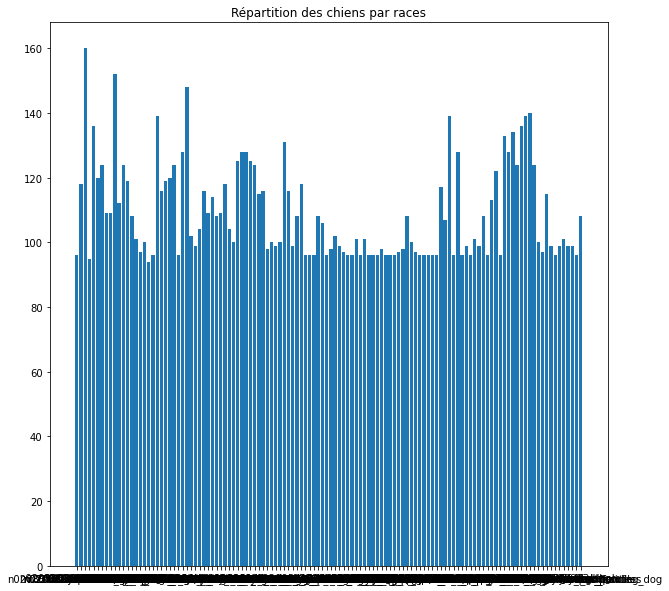

In [137]:
dict_train={}
for i in os.listdir('train'):
    dict_train[i]=0
    for j in os.listdir('train/{}'.format(i)):
        dict_train[i]+=1

keys = list(dict_train.keys())
values = list(dict_train.values())

plt.figure(figsize=(10,10))
plt.bar(keys,values)
plt.title("Répartition des chiens par races")
plt.show()

In [144]:
print(max(values))
print(min(values))

160
94


In [2]:
def affichage(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc)), acc, label='Training Accuracy')
    plt.plot(range(len(acc)), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(len(acc)), loss, label='Training Loss')
    plt.plot(range(len(acc)), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [3]:
results_CNN = pd.DataFrame({})
def errors_CNN(name,model,x_train,x_val,x_test):
    global results_CNN
    train=model.evaluate(x_train)
    val=model.evaluate(x_val)
    test=model.evaluate(x_test)
    results_CNN= results_CNN.append(pd.DataFrame({
        'Modèle': [name],
        'acc':train[1],
        'val_acc':val[1],
        'evaluate(x_test)_acc':test[1],
        'loss':train[0],
        'val_loss':val[0],
        'evaluate(x_test)_loss':test[0],
        }))

In [4]:
batch_size = 64  #64
num_classes = 120
size=150
epochs=50

# Modelisation de mon propre CNN

In [31]:
train_datagen = ImageDataGenerator(rotation_range=20,
                                   rescale=1./255,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.3,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

x_train = train_datagen.flow_from_directory(
    "train",
    color_mode= 'rgb',
    batch_size= batch_size,   
    target_size=(size, size),
    seed=123)

x_val = valid_datagen.flow_from_directory(
    "val",
    color_mode= 'rgb',
    batch_size= batch_size,
    target_size=(size, size),
    seed=123)

x_test = valid_datagen.flow_from_directory(
    "test",
    color_mode= 'rgb',
    batch_size= batch_size,
    target_size=(size, size),
    seed=123)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=3,verbose=1)


Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


### Modèle de base

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        1

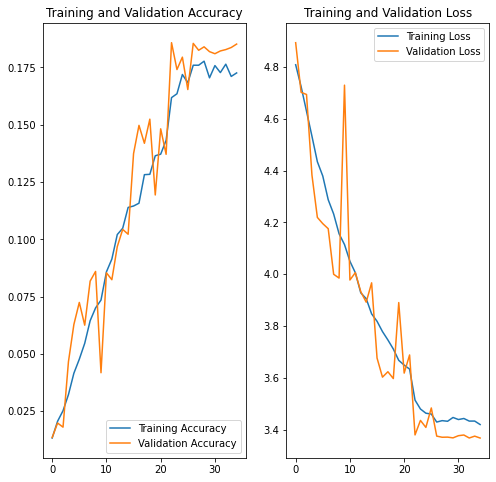

In [6]:
model = Sequential([
  
  Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(size, size, 3)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=32, kernel_size=3, activation='relu'),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=64, kernel_size=3, activation='relu'),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=128, kernel_size=3, activation='relu'),

  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=256, kernel_size=3, activation='relu'),
    
  Dropout(0.5),
  GlobalAveragePooling2D(),
  Dropout(0.5),
    
  Dense(num_classes, activation='softmax')
])

model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model.summary()

history = model.fit(
  x_train,
  validation_data=x_val,
  epochs=epochs,
  callbacks=[early_stopping, reduce_lr]
)

affichage(history)

In [32]:
errors_CNN("Modèle de base",model,x_train,x_val,x_test)

66/66 [==============================] - 11s 160ms/step - loss: 3.4043 - accuracy: 0.1860


### Modèle avec un kernel_regularizer en L2

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
batch_normalization_4 (Batch (None, 148, 148, 16)      64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 72, 72, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 64)       

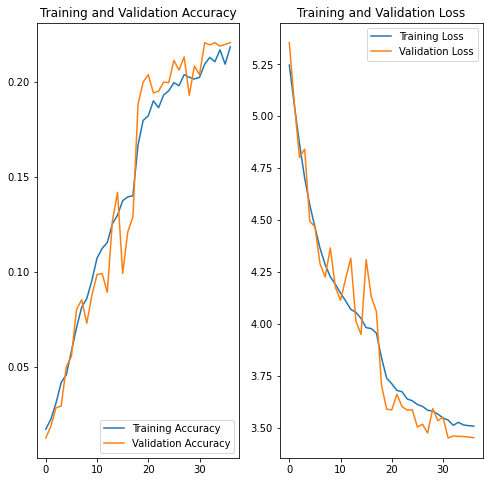

In [7]:
model_L2 = Sequential([
  
  Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(size, size, 3),kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=32, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=64, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=128, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),

  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=256, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  Dropout(0.5),
  GlobalAveragePooling2D(),
  Dropout(0.5),
    
  Dense(num_classes, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model_L2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model_L2.summary()

history_L2 = model_L2.fit(
  x_train,
  validation_data=x_val,
  epochs=epochs,
  callbacks=[early_stopping, reduce_lr]
)

affichage(history_L2)

In [33]:
errors_CNN("Modèle avec un kernel_regularizer en L2",model_L2,x_train,x_val,x_test)

66/66 [==============================] - 11s 161ms/step - loss: 3.4987 - accuracy: 0.2093


### Modèle de base sans Batch-Normalisation

Epoch 1/50
205/205 [==============================] - 139s 675ms/step - loss: 4.7776 - accuracy: 0.0118 - val_loss: 4.7140 - val_accuracy: 0.0168
Epoch 2/50
205/205 [==============================] - 134s 655ms/step - loss: 4.7102 - accuracy: 0.0151 - val_loss: 4.6492 - val_accuracy: 0.0216
Epoch 3/50
205/205 [==============================] - 299s 1s/step - loss: 4.6754 - accuracy: 0.0144 - val_loss: 4.6261 - val_accuracy: 0.0222
Epoch 4/50
205/205 [==============================] - 315s 2s/step - loss: 4.6491 - accuracy: 0.0159 - val_loss: 4.5783 - val_accuracy: 0.0265
Epoch 5/50
205/205 [==============================] - 306s 1s/step - loss: 4.6146 - accuracy: 0.0225 - val_loss: 4.5316 - val_accuracy: 0.0334
Epoch 6/50
205/205 [==============================] - 311s 2s/step - loss: 4.5495 - accuracy: 0.0254 - val_loss: 4.4574 - val_accuracy: 0.0355
Epoch 7/50
205/205 [==============================] - 312s 2s/step - loss: 4.4869 - accuracy: 0.0300 - val_loss: 4.3792 - val_accuracy: 

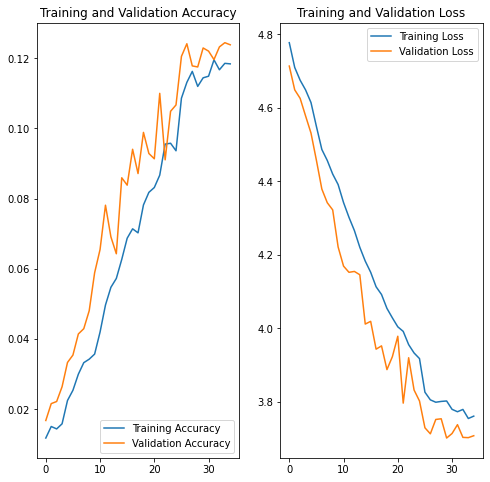

In [8]:
model_ss_batch = Sequential([
  
  Conv2D(filters=16, kernel_size=3, activation='relu', input_shape=(size, size, 3)),
    
  MaxPooling2D(),
    
  Conv2D(filters=32, kernel_size=3, activation='relu'),
    
  MaxPooling2D(),
    
  Conv2D(filters=64, kernel_size=3, activation='relu'),
    
  MaxPooling2D(),
    
  Conv2D(filters=128, kernel_size=3, activation='relu'),

  MaxPooling2D(),
    
  Conv2D(filters=256, kernel_size=3, activation='relu'),
    
  Dropout(0.5),
  GlobalAveragePooling2D(),
  Dropout(0.5),
    
  Dense(num_classes, activation='softmax')
])

model_ss_batch.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

history_ss_batch = model_ss_batch.fit(
  x_train,
  validation_data=x_val,
  epochs=epochs,
  callbacks=[early_stopping, reduce_lr]
)

affichage(history_ss_batch)

In [34]:
errors_CNN("Modèle de base sans Batch-Normalisation",model_ss_batch,x_train,x_val,x_test)

66/66 [==============================] - 9s 139ms/step - loss: 3.7552 - accuracy: 0.1213


### Modèle L2 avec kernel size à 4

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 147, 147, 16)      784       
_________________________________________________________________
batch_normalization_8 (Batch (None, 147, 147, 16)      64        
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 70, 70, 32)        8224      
_________________________________________________________________
batch_normalization_9 (Batch (None, 70, 70, 32)        128       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)       

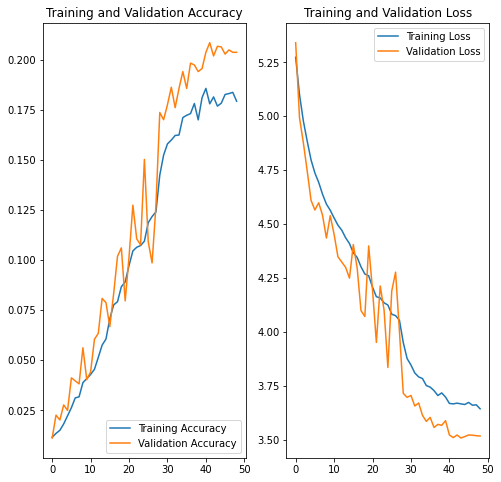

In [9]:
model_L2_kernel = Sequential([
  
  Conv2D(filters=16, kernel_size=4, activation='relu', input_shape=(size, size, 3),kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=32, kernel_size=4, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=64, kernel_size=4, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=128, kernel_size=4, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),

  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=256, kernel_size=4, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  Dropout(0.5),
  GlobalAveragePooling2D(),
  Dropout(0.5),
    
  Dense(num_classes, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model_L2_kernel.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model_L2_kernel.summary()

history_L2_kernel = model_L2_kernel.fit(
  x_train,
  validation_data=x_val,
  epochs=epochs,
  callbacks=[early_stopping, reduce_lr]
)

affichage(history_L2_kernel)

In [35]:
errors_CNN("Modèle L2 avec kernel size à 4",model_L2_kernel,x_train,x_val,x_test)

66/66 [==============================] - 11s 164ms/step - loss: 3.5450 - accuracy: 0.2062


### Modele L2 avec filtres plus faibles

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 148, 148, 8)       224       
_________________________________________________________________
batch_normalization_12 (Batc (None, 148, 148, 8)       32        
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 74, 74, 8)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 72, 72, 16)        1168      
_________________________________________________________________
batch_normalization_13 (Batc (None, 72, 72, 16)        64        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 34, 34, 32)       

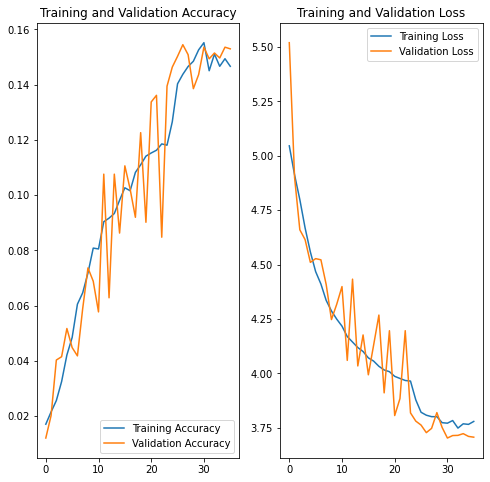

In [10]:
model_L2_filtres_1 = Sequential([
  
  Conv2D(filters=8, kernel_size=3, activation='relu', input_shape=(size, size, 3),kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=16, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=32, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=64, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),

  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=128, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  Dropout(0.5),
  GlobalAveragePooling2D(),
  Dropout(0.5),
    
  Dense(num_classes, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model_L2_filtres_1.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model_L2_filtres_1.summary()

history_L2_filtres_1 = model_L2_filtres_1.fit(
  x_train,
  validation_data=x_val,
  epochs=epochs,
  callbacks=[early_stopping, reduce_lr]
)

affichage(history_L2_filtres_1)

In [36]:
errors_CNN("Modele L2 avec filtres plus faibles",model_L2_filtres_1,x_train,x_val,x_test)

66/66 [==============================] - 8s 125ms/step - loss: 3.7476 - accuracy: 0.1538


### Modele L2 avec filtres décroissant

In [11]:
model_L2_filtres_2 = Sequential([
  
  Conv2D(filters=256, kernel_size=3, activation='relu', input_shape=(size, size, 3),kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=128, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=64, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=24, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),

  BatchNormalization(),
  MaxPooling2D(),
    
  Conv2D(filters=16, kernel_size=3, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    
  Dropout(0.5),
  GlobalAveragePooling2D(),
  Dropout(0.5),
    
  Dense(num_classes, activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.001))
])

model_L2_filtres_2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

model_L2_filtres_2.summary()

history_L2_filtres_2 = model_L2_filtres_2.fit(
  x_train,
  validation_data=x_val,
  epochs=epochs,
  callbacks=[early_stopping, reduce_lr]
)

affichage(history_L2_filtres_2)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 148, 148, 256)     7168      
_________________________________________________________________
batch_normalization_16 (Batc (None, 148, 148, 256)     1024      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 74, 74, 256)       0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 72, 72, 128)       295040    
_________________________________________________________________
batch_normalization_17 (Batc (None, 72, 72, 128)       512       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 34, 34, 64)       

KeyboardInterrupt: 

#### J'ai fait le choix de ne pas faire tourner ce modele jusqu'au bout car une epoch dure environ 20 minutes

In [38]:
#affichage des resultats
results_CNN

,Modèle,acc,val_acc,evaluate(x_test)_acc,loss,val_loss,evaluate(x_test)_loss
0,Modèle de base,0.237262,0.185152,0.185968,3.135489,3.367694,3.404314
0,Modèle avec un kernel_regularizer en L2,0.273470,0.220619,0.209274,3.283988,3.451272,3.498740
0,Modèle de base sans Batch-Normalisation,0.152089,0.123835,0.121336,3.608572,3.707709,3.755166
0,Modèle L2 avec kernel size à 4,0.232068,0.203787,0.206151,3.427375,3.517749,3.545023
0,Modele L2 avec filtres plus faibles,0.195936,0.152991,0.153772,3.566911,3.706983,3.747560


# Transfert learning

In [15]:
results = pd.DataFrame({})
def errors(name,model,x_train,x_val,x_test):
    global results
    train=model.evaluate(x_train)
    val=model.evaluate(x_val)
    test=model.evaluate(x_test)
    results = results.append(pd.DataFrame({
        'Modèle': [name],
        'acc':train[1],
        'val_acc':val[1],
        'evaluate(x_test)_acc':test[1],
        'loss':train[0],
        'val_loss':val[0],
        'evaluate(x_test)_loss':test[0],
        }))

## Les modèles ont tous été entrainés sur Google colab puis ils ont été évalués ici

### ResNet50, preprocess_input sur les données de validation, des couches ont été ajoutées au model, l'optimizeur est Nadam

In [16]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50,
                                   rotation_range=45,
                                   horizontal_flip = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.3,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50)

fpath = "train"
x_train = train_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

fpath= 'val'
x_val = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

fpath= 'test'
x_test = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


In [18]:
model_ResNet50 = load_model('model_ResNet50.h5')
errors("ResNet50_preprocess_couches_Nadam",model_ResNet50,x_train,x_val,x_test)

66/66 [==============================] - 90s 1s/step - loss: 1.3963 - accuracy: 0.6713


### ResNet50, preprocess_input sur les données de validation, des couches ont été ajoutées au model, kernel_regularizer = L2, l'optimizeur est Nadam

In [19]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50,
                                   rotation_range=45,
                                   horizontal_flip = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.3,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50)

fpath = "train"
x_train = train_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

fpath= 'val'
x_val = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

fpath= 'test'
x_test = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


In [20]:
model_ResNet50_2 = load_model('model_ResNet50_2.h5')

errors("ResNet50_preprocess_couches_Nadam_L2",model_ResNet50_2,x_train,x_val,x_test)

66/66 [==============================] - 89s 1s/step - loss: 1.5901 - accuracy: 0.6699


### ResNet50, normalisation des données de validation, sans couches ajoutées, l'optimizeur est Nadam

In [21]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input_resnet50,
                                   rotation_range=45,
                                   horizontal_flip = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.3,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(rescale=1./255)

fpath = "train"
x_train = train_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

fpath= 'val'
x_val = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

fpath= 'test'
x_test = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))


Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


In [22]:
model_ResNet50_3 = load_model('model_ResNet50_3.h5')

errors("ResNet50_Rescale_Nadam",model_ResNet50_3,x_train,x_val,x_test)


66/66 [==============================] - 89s 1s/step - loss: 5.1554 - accuracy: 0.0077


### InceptionV3, preprocess_input sur les données de validation, sans couches ajoutées, l'optimizeur est Nadam


In [23]:
train_datagen = ImageDataGenerator(preprocessing_function=inception_v3_preprocessor,
                                   rotation_range=45,
                                   horizontal_flip = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.3,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(preprocessing_function=inception_v3_preprocessor)

fpath = "train"
x_train = train_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

fpath= 'val'
x_val = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

fpath= 'test'
x_test = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size))

Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


In [24]:
model_InceptionV3 = load_model('model_InceptionV3.h5')

errors("InceptionV3_preprocess_Nadam",model_InceptionV3,x_train,x_val,x_test)


66/66 [==============================] - 41s 614ms/step - loss: 1.4153 - accuracy: 0.6377


### Xception, preprocess_input sur les données de validation, des couches ont été ajoutées au model, l'optimizeur est Adam

In [25]:
train_datagen = ImageDataGenerator(preprocessing_function=Xception_preprocessor,
                                   rotation_range=45,
                                   horizontal_flip = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.3,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(preprocessing_function=Xception_preprocessor)

fpath = "train"
x_train = train_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size),
    seed=123)

fpath= 'val'
x_val = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size),
    seed=123)

fpath= 'test'
x_test = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= batch_size,
    target_size=(size, size),
    seed=123)


Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


In [26]:
model_x = load_model('model_x.h5')

errors("Xception_preprocess_couches_Adam",model_x,x_train,x_val,x_test)

66/66 [==============================] - 83s 1s/step - loss: 1.4371 - accuracy: 0.6499


### Xception, preprocess_input sur les données de validation, des couches differentes ont été ajoutées au model, l'optimizeur est un Adam(learning_rate=0.001)


In [28]:
train_datagen = ImageDataGenerator(preprocessing_function=Xception_preprocessor,
                                   rotation_range=45,
                                   horizontal_flip = True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   zoom_range = 0.3,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(preprocessing_function=Xception_preprocessor)


fpath = "train"
x_train = train_datagen.flow_from_directory(
    fpath,  
    shuffle= True,
    class_mode="categorical", 
    batch_size= 32,
    target_size=(size, size))

fpath= 'val'
x_val = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    class_mode="categorical",
    batch_size= 32,
    target_size=(size, size))

fpath= 'test'
x_test = valid_datagen.flow_from_directory(
    fpath,  
    shuffle= True, 
    batch_size= 32,
    target_size=(size, size))

Found 13091 images belonging to 120 classes.
Found 3327 images belonging to 120 classes.
Found 4162 images belonging to 120 classes.


In [29]:
model_Xception = load_model('model_Xception.h5')

errors("Xception_preprocess_couches_Adam(lr)",model_Xception,x_train,x_val,x_test)

131/131 [==============================] - 80s 612ms/step - loss: 1.3300 - accuracy: 0.6413


In [30]:
results

,Modèle,acc,val_acc,evaluate(x_test)_acc,loss,val_loss,evaluate(x_test)_loss
0,ResNet50_preprocess_couches_Nadam,0.807272,0.672077,0.671312,0.920801,1.356514,1.396273
0,ResNet50_preprocess_couches_Nadam_L2,0.828585,0.674482,0.669870,1.056592,1.553139,1.590072
0,ResNet50_Rescale_Nadam,0.670613,0.006913,0.007689,1.148853,5.154705,5.155365
0,InceptionV3_preprocess_Nadam,0.628141,0.646528,0.637674,1.351926,1.402472,1.415317
0,Xception_preprocess_couches_Adam,0.654648,0.657349,0.649928,1.386356,1.405062,1.437149
0,Xception_preprocess_couches_Adam(lr),0.618975,0.649234,0.641278,1.474160,1.319318,1.330024


# Essai de notre meilleur modele avec des images libres de droit trouvées sur le net

In [87]:
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(150, 150))
    img_tensor = image.img_to_array(img) 
    img_tensor = np.expand_dims(img_tensor, axis=0) 
    img_tensor = preprocess_input(img_tensor)                                 

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


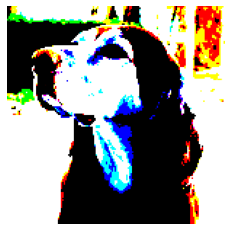

n02089078-black-and-tan_coonhound


In [88]:
new_image = load_image("test/n02089078-black-and-tan_coonhound/n02089078_1668.jpg",show=True)
pred = model_ResNet50.predict(new_image)
classes = x_test.class_indices 
list_of_key = list(classes.keys())
list_of_value = list(classes.values())
 
position = list_of_value.index(list((pred==pred.max())[0]).index(True))
print(list_of_key[position])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


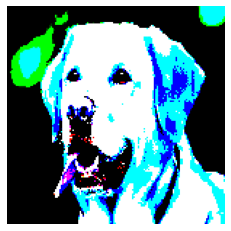

n02099601-golden_retriever


In [145]:
new_image = load_image("labrador.jpg",show=True)
pred = model_ResNet50.predict(new_image)
classes = x_test.class_indices 
list_of_key = list(classes.keys())
list_of_value = list(classes.values())
 
position = list_of_value.index(list((pred==pred.max())[0]).index(True))
print(list_of_key[position])

In [149]:
new_image = load_image("apa.jpg")
pred = model_ResNet50.predict(new_image)
classes = x_test.class_indices 
list_of_key = list(classes.keys())
list_of_value = list(classes.values())
 
position = list_of_value.index(list((pred==pred.max())[0]).index(True))
print(list_of_key[position])

n02100735-English_setter
